In [733]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [734]:
# Constants
N_SPLITS = 20
RANDOM_STATE = 42

In [735]:
# Load and preprocess data
cleaned_offences = pd.read_csv('../cleanedCsv/cleanedOffences.csv')

# Rename columns
cleaned_offences.rename(columns={
  'Local Government Area': 'LGA',
  'Year': 'year'
}, inplace=True)

# Calculate population from rate and offence count
cleaned_offences['population'] = cleaned_offences['Offence Count'] / cleaned_offences['Rate per 100,000 population'] * 100000

# Drop columns that are not needed
cleaned_offences.drop(columns=[
    'Offence Count',
    'Rate per 100,000 population',
], inplace=True)

# Drop total rows because we only need LGA
cleaned_offences = cleaned_offences[cleaned_offences['LGA'] != 'total']

# Create a new dataframe to store population data
population_data = pd.DataFrame({
    'last_year_population': [],
    'year': [],
    'LGA': [],
})

# Lag population by 1 year for each LGA
# Remove 2014 from table because we don't have population data for 2013
for LGA, group in cleaned_offences.groupby('LGA'):
    group['last_year_population'] = group['population'].shift(1)
    # group['last_year_population'] = group['population'].mean()
    group = group.dropna()
    population_data = pd.concat([population_data, group], ignore_index=True)
    population_data.drop(columns=['Unnamed: 0'], inplace=True)

# Features we want to use
features = [
    'last_year_population',
    'year',
]

In [736]:
# Linear Regression using KFold cross validation for each LGA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

model_data = population_data.copy()

# One-hot encode LGA column
unique_lga_names = model_data['LGA'].apply(lambda x: 'LGA_' + x).unique()
model_data_encoded = pd.get_dummies(model_data, columns=['LGA'])

# Combine one-hot encoded LGA columns with other features
features_new = [
    *features,
    *unique_lga_names
]

model = LinearRegression()

rmse_values = []

kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

# for lga, group in model_data:
X = model_data_encoded[features_new]
y = model_data_encoded['population'] # From population_data dataframe

for train_index, test_index in kf.split(X):
    # Split the data into training and testing sets for the current fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_values.append(rmse)

print("Root Mean Squared Error (RMSE):", np.mean(rmse_values))

Root Mean Squared Error (RMSE): 1900.6804448732837


/var/folders/19/534nl8853rg0sycn60dtsltr0000gn/T/ipykernel_39447/2782907400.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0].legend()


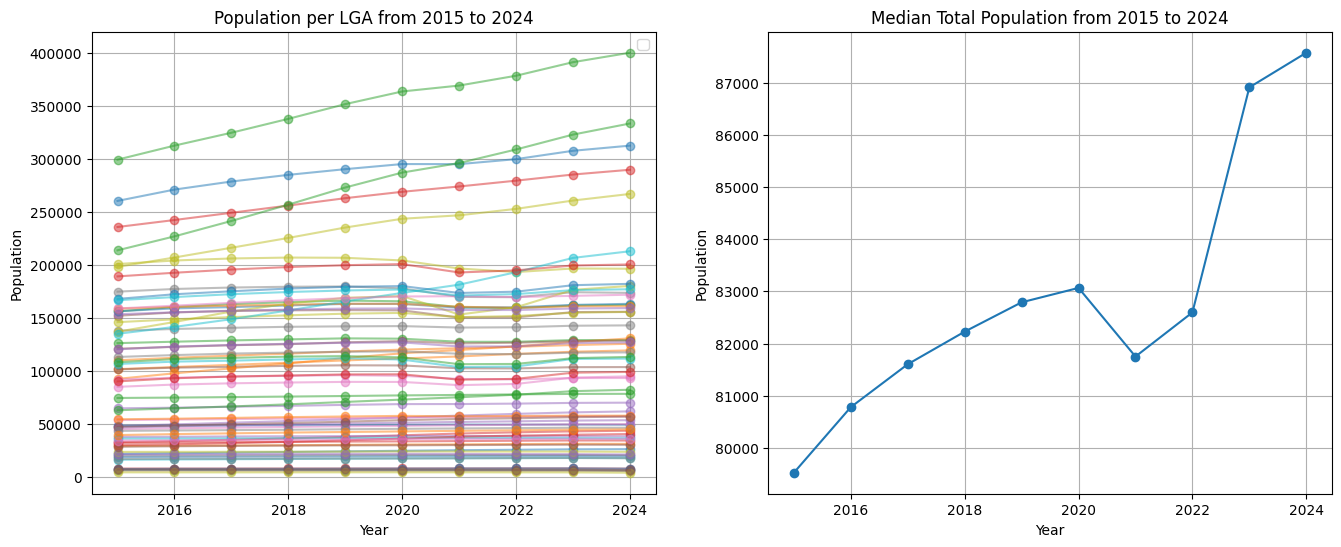

In [780]:
# Predict 2024 population for each LGA
predict_data = model_data_encoded[features_new]
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

combined_population_data = []

for location in predict_data.columns:
    if 'LGA_' not in location:
        continue

    most_recent_year = 2023
    predict_year = 2024

    input_data = model_data_encoded[(model_data_encoded[location] == True) & (model_data_encoded['year'] == most_recent_year)]
    input_data = input_data.copy()
    input_data['last_year_population'] = input_data['population']
    input_data['year'] = predict_year

    # Only keep feature columns
    input_data = input_data[features_new]

    y_pred = model.predict(input_data)
    # print(f'{predict_year} predicted population:', y_pred[0])
    # print(f'{most_recent_year} population:', input_data['last_year_population'].iloc[0])

    historic_rows = model_data_encoded[model_data_encoded[location] == True][['year', 'population']]
    predicted_row = pd.DataFrame({'year': predict_year, 'population': y_pred[0]}, index=[0])
    population_rows = pd.concat([historic_rows, predicted_row], ignore_index=True)

    for index, row in population_rows.iterrows():
        combined_population_data.append({
            'year': row['year'],
            'population': row['population'],
        })

    # Normalise
    # population_rows['population'] = (population_rows['population'] - population_rows['population'].min()) / (population_rows['population'].max() - population_rows['population'].min())

    axes[0].plot(population_rows['year'], population_rows['population'], marker='o', alpha=0.5)

axes[0].set_title('Population per LGA from 2015 to 2024')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Population')
axes[0].legend()
axes[0].grid(True)

# Plot median population across all LGA
combined_population_data = pd.DataFrame(combined_population_data)

axes[1].plot(combined_population_data.groupby('year')['population'].median(), marker='o')
axes[1].set_title('Median Total Population from 2015 to 2024')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Population')
axes[1].grid(True)

plt.show()

In [741]:
# Generate predictions and save to CSV
predict_data = model_data_encoded[features_new]

prediction_results = {}

for location in predict_data.columns:
    if 'LGA_' not in location:
        continue

    most_recent_year = 2023
    predict_year = 2024

    input_data = model_data_encoded[(model_data_encoded[location] == True) & (model_data_encoded['year'] == most_recent_year)]
    input_data = input_data.copy()
    input_data['last_year_population'] = input_data['population']
    input_data['year'] = predict_year

    # Only keep feature columns
    input_data = input_data[features_new]

    y_pred = model.predict(input_data)

    prediction_results[location] = round(y_pred[0])

prediction_results = pd.DataFrame(prediction_results.items(), columns=['LGA', 'Population'])
prediction_results['LGA'] = prediction_results['LGA'].apply(lambda x: x.replace('LGA_', ''))
prediction_results.to_csv('2024_populations.csv')

In [750]:
# Null model, using static mean as prediction
rmse_values = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    y_mean = np.mean(y_train)
    rmse = np.sqrt(mean_squared_error(y_test, [y_mean] * len(y_test)))
    rmse_values.append(rmse)

print("Null Model RMSE:", np.mean(rmse_values))

Null Model RMSE: 76747.97702602603


In [748]:
# Baseline model (using previous year's population as prediction for current year)
rmse_values = []

# K-fold cross-validation for naive baseline model
for train_index, test_index in kf.split(X):
    # Training and test sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Baseline model: predict using the mean of the training set
    y_baseline_pred = X_test['last_year_population']  # Predict using the last year's population
    
    # Calculate RMSE for the current fold
    rmse = np.sqrt(mean_squared_error(y_test, y_baseline_pred))
    rmse_values.append(rmse)

print(f"Baseline Model RMSE: {np.mean(rmse_values)}")

Baseline Model RMSE: 3477.9506598029425
